#  Big Picture

The target of this project is to find the relationship between housing value in California with other available features such as: median income, housing age, number of room in a house, etc. This is an end-to-end project, we will go through all stages of the real-time project as import, fetch data, prepare data, cleaning, choosing the right model, fine tuning the model, visualize the results and others. 

*Keyword*: supervised learning, California housing value

# 1. Import the libraries

In [1]:
##### ALL THE LIBRARIES FOR THIS PROJECT
import os
import tarfile
from six.moves import urllib
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np
import hashlib 
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

# 2. Fetch the data

**Fetch data**: fetch data from the Internet, create its workspace (folders contain the dataset), download and automatically extract the file to csv. file (using os library to do so)

In [2]:
######## FETCH THE DATA  #########
##################################
dlblue = '#0096ff'; dlorange = '#FF9300'; dldarkred='#C00000';
dlmagenta='#FF40FF'; dlpurple='#7030A0'; 

%matplotlib inline

def print_hashline(number_of_hash=40):
    print('#'*number_of_hash)

print('#### CALIFORNIA HOUSING VALUE PROJECT ####')
print_hashline()
print_hashline()

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

if not os.path.isdir(HOUSING_PATH):
    fetch_housing_data()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)
housing = load_housing_data()

#Description of the dataset
print('##### HOUSING TABLE AND DESCRIPTION #####')
print(housing.head(n=5))
housing.info()
parameter = "housing_median_age"
print(housing[parameter].value_counts())
print(housing[parameter].describe())

#### CALIFORNIA HOUSING VALUE PROJECT ####
########################################
########################################
##### HOUSING TABLE AND DESCRIPTION #####
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms   
0    -122.23     37.88                41.0        880.0           129.0  \
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0      

There are many methods we can use to visualize the dataset in Pandas:
- pd.head(): look at top rows of dataset.
- pd.info(): show overall description of the dataset.
- pd.value_counts(): find categories and number of values in each.
- pd.describe(): summary of the numerical attributes.
- pd.hist(): create a histogra for each numerical attributes.

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

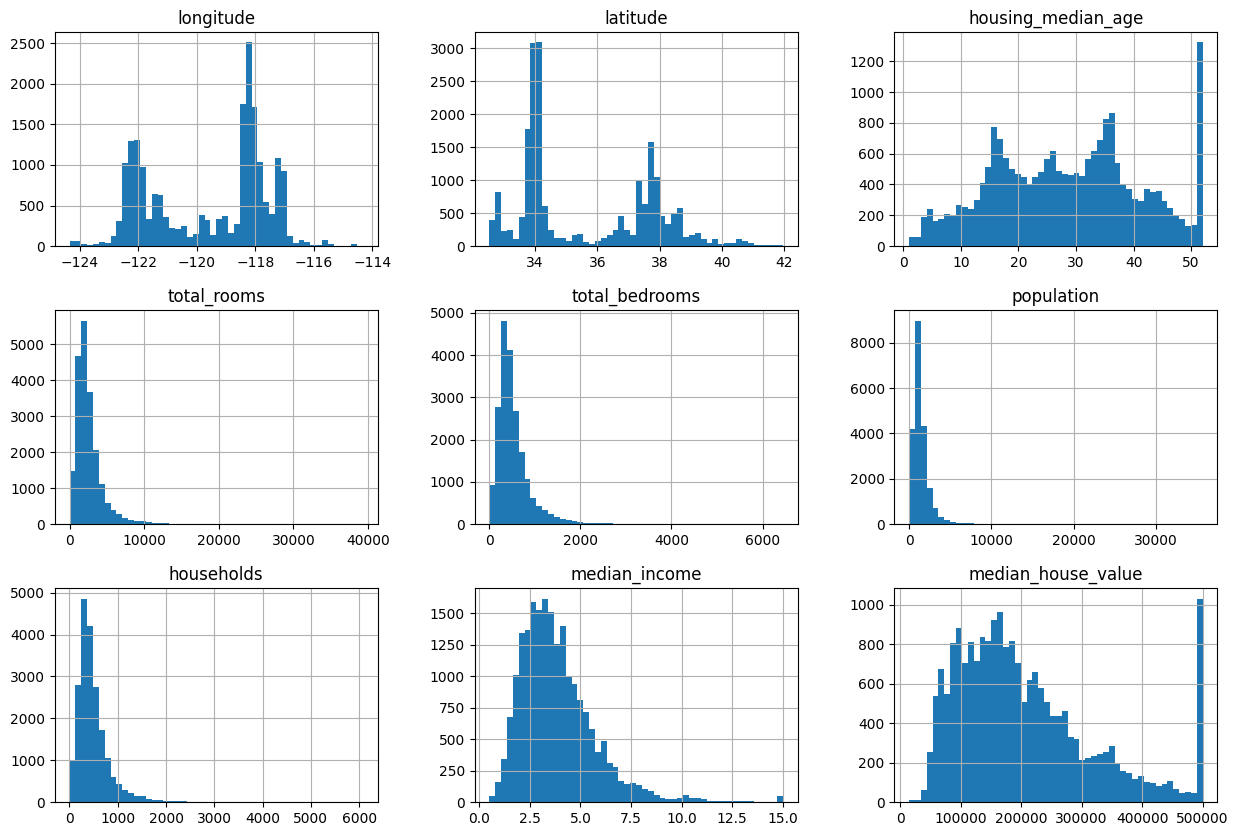

In [3]:
#Housing histogram with all features
housing.hist(bins=50,figsize=(15,10))

# 3. Training and test set

Given a dataset to build a model, we should split it into 2 subsets: (1) train set and (2) test set (usually 20% or 30% for the test set). <br>

Sometimes, even we have to split into 3 subsets: train set, cross-validation set and test set (50%:25%:25%). This is due to the model is only evaluated on one specific partition of the data, which may not be representative of the true performance of the model.
- The train set is used to train the model. 
- The cross-validation set is used to tune the hyperparameters of the model, such as the learning rate, regularization parameters, or the number of layers in a neural network. 
- The test set is used to evaluate the final performance of the model after the hyperparameters have been tuned.

In [4]:
######### CREATE A TRAINING DATASET AND A TEST SET ##########
#############################################################
def plit_train_test(data, ratio):
    '''This function is to plit the dataset into 2 kinds of data:
        Training data and test dataset using the plitting ratio
        1st step: shuffer the dataset indices
        2nd step: return a test/ training data size
        3rd step: return the plitting indices into test and training dataset
    '''
    shuffered_indices = np.random.permutation(len(data))
    test_data_size = int(len(data)*ratio)
    train_indices = shuffered_indices[test_data_size:]
    test_indices = shuffered_indices[:test_data_size]
    return data.iloc[train_indices], data.iloc[test_indices]

To avoid different dataset everytime we re-run the program, there are many methods:
1. Save the dataset in the first run and load it again subsequently
2. Use seed() for random 
3. Use hash()

<br> The function below is applied the method 3: using hash()

In [5]:
##### FUNCTION WITH RAEAINED SPLIT DATASET THROUGH SUBSEQUENT RUN #####
def test_set_check(identifier, test_ratio, hash):
    '''compute a hash of each instance’s identifier, keep only the last
    byte of the hash, and put the instance in the test set if this value 
    is lower or equal to 51 (~20% of 256)
    '''
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    print(in_test_set)
    return data.loc[~in_test_set], data.loc[in_test_set]

In [6]:
test_ratio = 0.2
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, test_ratio, 'index')
print('THIS IS THE LENGTH OF TRAIN AND TEST SET:')
print(len(train_set),' train + ',len(test_set),' test')

0        False
1        False
2        False
3        False
4         True
         ...  
20635    False
20636    False
20637     True
20638    False
20639    False
Name: index, Length: 20640, dtype: bool
THIS IS THE LENGTH OF TRAIN AND TEST SET:
16362  train +  4278  test


In [7]:
# sklearn has the same splitting function as we defined before
train_set, test_set = train_test_split(housing, test_size = 0.2, random_state=42)
print(train_set.head(10))
print(test_set.head(10))

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms   
14196    -117.03     32.71                33.0       3126.0           627.0  \
8267     -118.16     33.77                49.0       3382.0           787.0   
17445    -120.48     34.66                 4.0       1897.0           331.0   
14265    -117.11     32.69                36.0       1421.0           367.0   
2271     -119.80     36.78                43.0       2382.0           431.0   
17848    -121.86     37.42                20.0       5032.0           808.0   
6252     -117.97     34.04                28.0       1686.0           417.0   
9389     -122.53     37.91                37.0       2524.0           398.0   
6113     -117.90     34.13                 5.0       1126.0           316.0   
6061     -117.79     34.02                 5.0      18690.0          2862.0   

       population  households  median_income  median_house_value   
14196      2300.0       623.0         3.2596            103000

Two function above and train_test_split of sklearn lib RANDOMLY selected the splitting indices in the dataset and return it into the test, train sets. This can cause sampling bias, to deal with this problem we should base on the principle of "stratified sampling" to split the data set. <br>

**Stratified sampling**: population is devided into homogeneous subgroups called *strata*, and the right number of intances is sampled from each stratum to guarantee that the test set is representative of the overall population. <br>

In sklearn, there is a function: "StratifiedShuffleSplit()" to overcome this situation. Categorize the attributes to find representive numbers for the population dataset. Now, let's create catergories of a dataset based on "median_icome" into 5 categories (5 bins) note that the catergories greater than 5 will be merged in to "5.0" catergories.

In [8]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)  

print('THIS IS THE DESCRIPTION OF INCOME CATEGORIES:')
print(housing["income_cat"].describe())

THIS IS THE DESCRIPTION OF INCOME CATEGORIES:
count    20640.000000
mean         3.006686
std          1.054618
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: income_cat, dtype: float64


<Axes: >

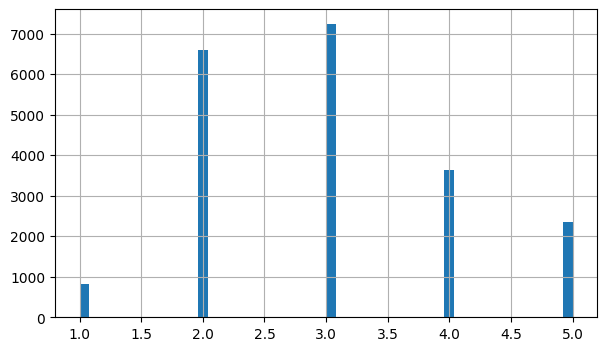

In [9]:
#Histogram of feature 'income_cat' with 5 bins
housing["income_cat"].hist(bins=50, figsize=(7,4))

In [10]:
#Create income_cat for random test set
test_set["income_cat"] = np.ceil(test_set["median_income"] / 1.5)
test_set["income_cat"].where(test_set["income_cat"] < 5, 5.0, inplace=True)  

#Use StratifiedShffleSplit to create train and test sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

What is Stratified Sampling?
- Stratified Sampling is a technique that is used to devide a population into homogeneous subgroups called strata, and the right number of instances is sampled from each stratum to guarantee that the test set is represengtive of the overall population.

In sklearn stratification can be done by StratifiedShuffleSplit(), this ensures that the proportions of different classes is maintained in both the training and test set.

In [11]:
#Find the proportion of the whole data set to compared with random and stratified sets
por_overall = np.array(housing["income_cat"].value_counts() / len(housing))
por_strat = np.array(strat_test_set["income_cat"].value_counts() / len(strat_test_set))
por_random = np.array(test_set["income_cat"].value_counts()/ len(test_set))

### ERROR OF RANDOM AND STRATIFIED DATASET TABLE###
print('{:>5s}{:>15s}{:>15s}{:>15s}{:>20s}{:>22s}'. format('No.', 'Overall', 'Random', 'Stratified', 
                                                      'Random error (%)', 'Stratified error(%)'))
error_random = np.zeros(por_random.shape)
error_strat = np.zeros (por_strat.shape)
for i in range(por_overall.size):
    error_random[i] = abs(por_overall[i]-por_random[i])/por_overall[i]
    error_strat[i] = abs(por_overall[i]-por_strat[i])/por_overall[i]
    print('{:5d}{:>15f}{:>15f}{:>15f}{:>20f}{:>22f}'.
        format(i, por_overall[i], por_random[i], por_strat[i], 
            error_random[i]*100, error_strat[i]*100))
print('\n')


  No.        Overall         Random     Stratified    Random error (%)   Stratified error(%)
    0       0.350581       0.358527       0.350533            2.266446              0.013820
    1       0.318847       0.324370       0.318798            1.732260              0.015195
    2       0.176308       0.167393       0.176357            5.056334              0.027480
    3       0.114438       0.109496       0.114341            4.318374              0.084674
    4       0.039826       0.040213       0.039971            0.973236              0.364964




In [12]:
##remove income_cat attribute so that the data back to original
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# 4. Discover and visualize data

Text(0.5, 1.0, 'longitude vs latitude, alpha = 0.1')

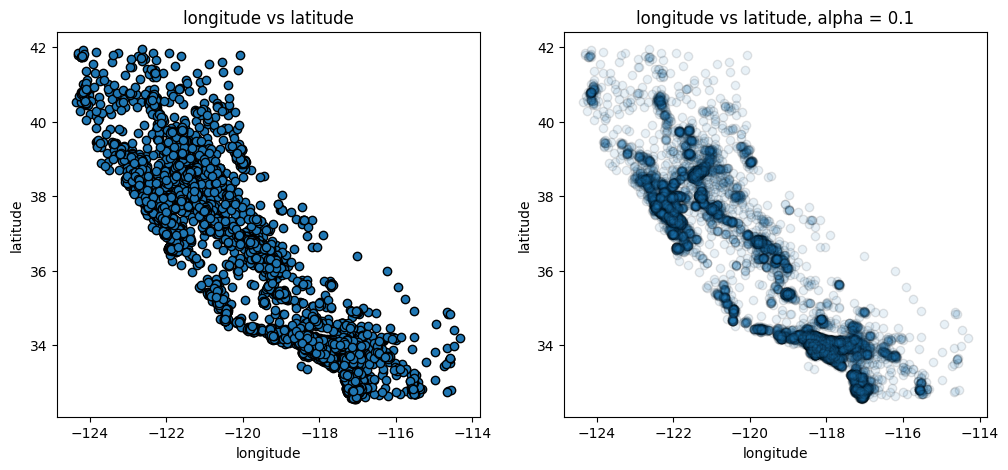

In [13]:
###### DISCOVER AND VISUALIZE DATA ########
###########################################

#Create a copy so so that won't harm the training set
housing = strat_train_set.copy() 

#Geographical visualization
fig,ax = plt.subplots(1,2,figsize=(12,5))
ax[0].scatter(housing['longitude'], housing['latitude'], edgecolors='black' )
ax[1].scatter(housing['longitude'], housing['latitude'], edgecolors='black', alpha = 0.1,)
ax[0].set_xlabel('longitude'); ax[0].set_ylabel('latitude')
ax[1].set_xlabel('longitude'); ax[1].set_ylabel('latitude')
ax[0].set_title('longitude vs latitude'); ax[1].set_title('longitude vs latitude, alpha = 0.1') 

Using alpha in scatter() to clarify the density of points (0 <= apha <= 1). The figure below show the housing distribution in California, the gradient colow illustrates the housing values, size of bubble points show the population.

<Axes: title={'center': 'Housing density in California'}, xlabel='longitude', ylabel='latitude'>

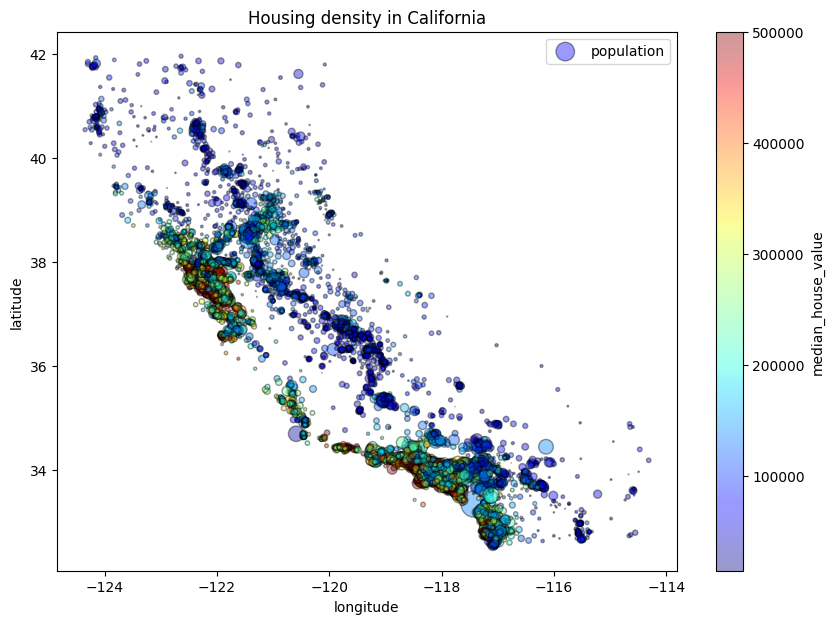

In [14]:
#Plot by visulization show: density of house, housing value by color, population by bubble plot
housing.plot(kind='scatter', x='longitude', y='latitude', edgecolors='black', 
            alpha=0.4, title='Housing density in California', s=housing['population']/100, 
            label='population', figsize=(10,7), c='median_house_value', cmap=plt.get_cmap('jet'), 
            colorbar=True)

Finding the house value is the objective of this project. Firstly, we should see some correlations between median_house_value (target) against other attributes to pick out the promising attribute that has strong relation with the house value. <br>

In corr_matrix(), using method of Pearson's r correlation coefficient (-1 <= r <= 1). In which if r is closer to -1 or 1 show the strong negative or positive correlation, if r is closer to 0 show no correlation!

THIS IS CORRELATION COEFFICIENT OF HOUSING VALUES VS OTHERS:
median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64
########################################


array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

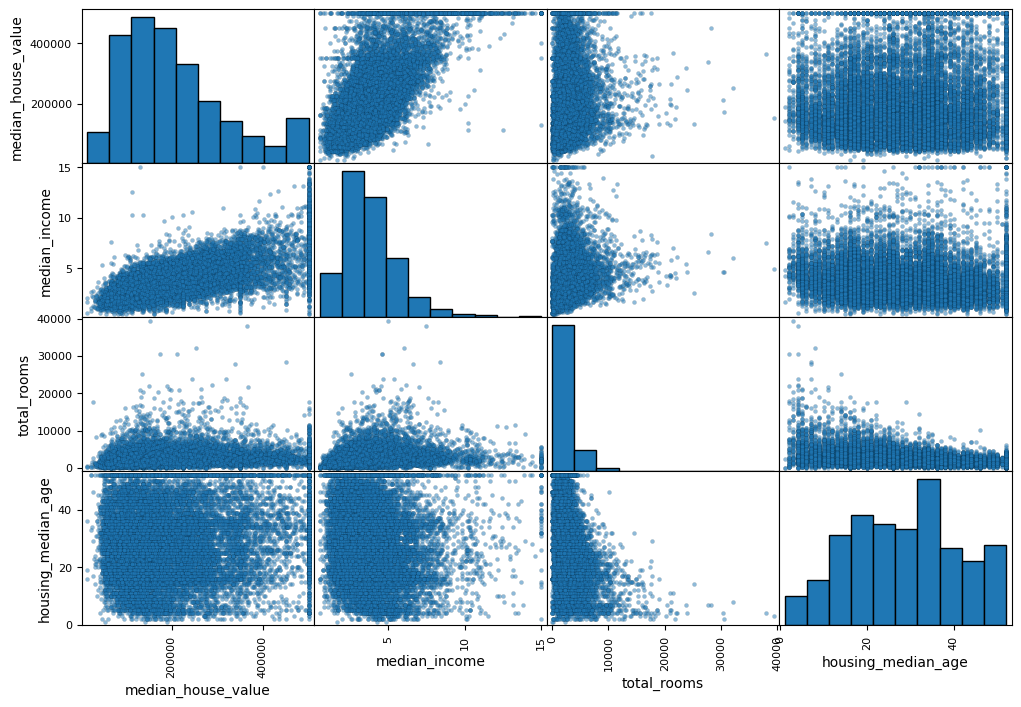

In [15]:
#Creat housing set that contain only number dtype
corr_matrix = housing.select_dtypes(include='number').corr()
print('THIS IS CORRELATION COEFFICIENT OF HOUSING VALUES VS OTHERS:')
print(corr_matrix['median_house_value'].sort_values(ascending=False))
print_hashline()

#Visualization correlation by scatterring
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12,8), alpha=0.5, hist_kwds={'edgecolor': 'black'},
                grid=True, marker='.', s=35, edgecolor='black', linewidths=0.1)

From now we can see that median_income has the significant linear correlation with median_house_value, let's check it out.

<Axes: title={'center': 'Housing value vs median income'}, xlabel='median_income', ylabel='median_house_value'>

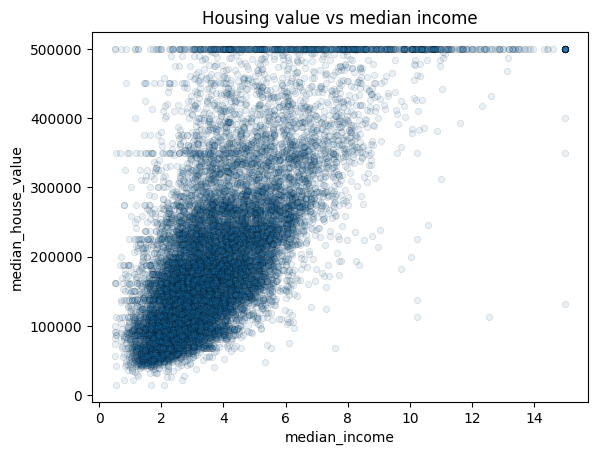

In [16]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1,
            edgecolor='black', linewidths=0.7, title='Housing value vs median income')

Given a dataset, we not just use the attributes themselves, we should combine things together. Who knows there will be something insights can be discovered. Combine attributes by multiple, plus, take proportion, etc. of them.

In [17]:
#Combine attributes
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

#Description of new combinations
print(housing.describe())


          longitude      latitude  housing_median_age   total_rooms   
count  16512.000000  16512.000000        16512.000000  16512.000000  \
mean    -119.575635     35.639314           28.653404   2622.539789   
std        2.001828      2.137963           12.574819   2138.417080   
min     -124.350000     32.540000            1.000000      6.000000   
25%     -121.800000     33.940000           18.000000   1443.000000   
50%     -118.510000     34.260000           29.000000   2119.000000   
75%     -118.010000     37.720000           37.000000   3141.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income   
count    16354.000000  16512.000000  16512.000000   16512.000000  \
mean       534.914639   1419.687379    497.011810       3.875884   
std        412.665649   1115.663036    375.696156       1.904931   
min          2.000000      3.000000      2.000000       0.499900   
25%        295.00000

In [18]:
#Correlation of new attributes and housing value
orr_matrix = housing.select_dtypes(include='number').corr()
print('THIS IS THE CORRELATION COEFFICIENT OF HOUSING VALUES VS OTHERS (COMBINED ATTRIBUTES INCLUDED)')
print(corr_matrix['median_house_value'].sort_values(ascending=False))
print_hashline()

THIS IS THE CORRELATION COEFFICIENT OF HOUSING VALUES VS OTHERS (COMBINED ATTRIBUTES INCLUDED)
median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64
########################################


array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='rooms_per_household', ylabel='median_house_value'>,
        <Axes: xlabel='bedrooms_per_room', ylabel='median_house_value'>,
        <Axes: xlabel='population_per_household', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='rooms_per_household'>,
        <Axes: xlabel='rooms_per_household', ylabel='rooms_per_household'>,
        <Axes: xlabel='bedrooms_per_room', ylabel='rooms_per_household'>,
        <Axes: xlabel='population_per_household', ylabel='rooms_per_household'>],
       [<Axes: xlabel='median_house_value', ylabel='bedrooms_per_room'>,
        <Axes: xlabel='rooms_per_household', ylabel='bedrooms_per_room'>,
        <Axes: xlabel='bedrooms_per_room', ylabel='bedrooms_per_room'>,
        <Axes: xlabel='population_per_household', ylabel='bedrooms_per_room'>],
       [<Axes: xlabel='median_house_value', ylabel='population_per_household'>,
        <Ax

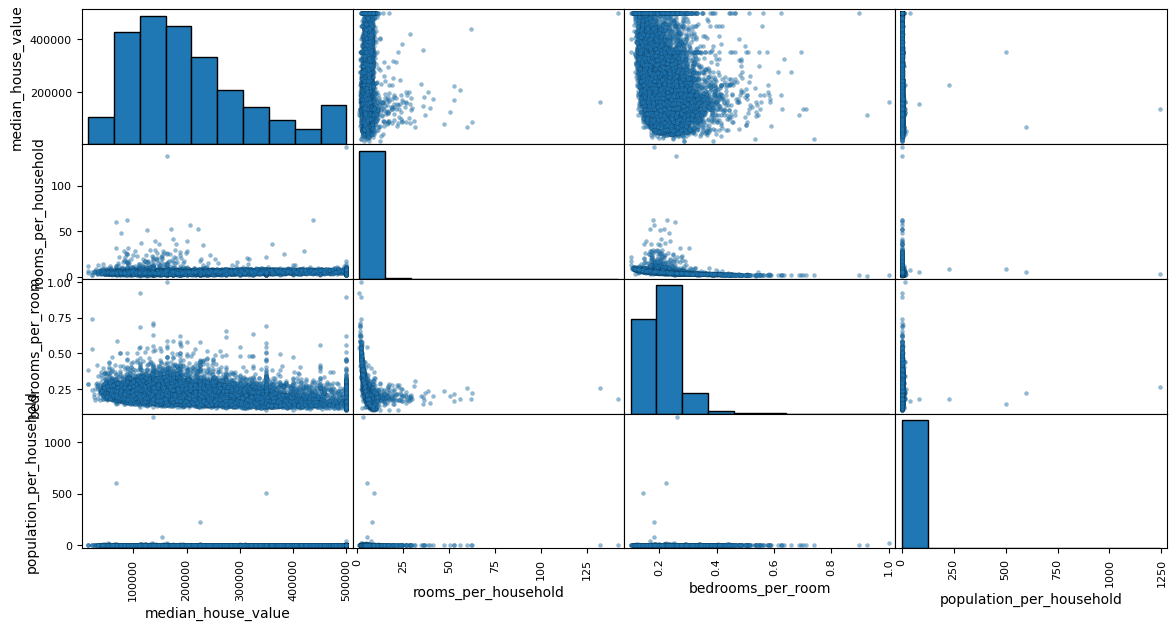

In [19]:
attributes = ['median_house_value', 'rooms_per_household', 
            'bedrooms_per_room', 'population_per_household']
scatter_matrix(housing[attributes], figsize=(14,7), alpha=0.5, hist_kwds={'edgecolor': 'black'},
            grid=True, marker='.', s=35, edgecolor='black', linewidths=0.1)

# 5. Prepare data for machine learning

In [20]:
############ PREPARE DATA FOR MACHINE LEARNING #############
############################################################

#Drop just make a copy, no impact on strat_train_set
housing = strat_train_set.drop("median_house_value", axis=1)   

#Separate predictors and label (so-called target value)
housing_labels = strat_train_set["median_house_value"].copy()  

## 5.1. Dealing with missing data

Notice that some value in the attribute total_bedrooms are missing, we can correct by:
- Option 1: Get rid of the correspoding districts.
- Option 2: Get rid of the whole attributes
- Option 3: Set to some values (zero, mean, median)

In [21]:
housing.dropna(subset=['total_bedrooms'])   #option 1
housing.drop('total_bedrooms', axis=1)      #option 2
median = housing['total_bedrooms'].median() #option 3
housing['total_bedrooms'].fillna(median, inplace=True) 

We can use the library Imputer from sklearn to replace missing value by various methods mentioned above. Now, let us undergo through a simple process of how to filling missing value by computing median using Imputer

In [22]:
#Use Imputer from sklearn to replace missing values
#Housing without text attributes 'ocean_proximity'
housing_num = housing.drop('ocean_proximity', axis=1) 
#Create instance in Imputer
imputer = SimpleImputer(strategy='median')  
#Fit imputer to data      
imputer.fit(housing_num)                    
#Transform data to fill missing values
X = imputer.transform(housing_num)          
#Put back into pandas DataFrame
housing_tr = pd.DataFrame(X, columns=housing_num.columns)  

## 5.2. Handling with categorical attribute

Machine Learning prefers to work with numbers, we must categorize the text-based or categorical attributes into numerical attributes. There are many encoding methods:
1. Label encoding,
2. One-hot encoding,
3. Binary encoding,
4. Frequency encoding, etc.

In [23]:
#Create a categorical attributes array
housing_cat = housing['ocean_proximity']

#Label encoding (not prefer for this kind of categories of ocean_proximity)
housing_cat_encoded, housing_cat_categories = housing_cat.factorize()
print(housing_cat_encoded[:10])
print(housing_cat_categories)

[0 1 0 1 2 3 2 2 2 2]
Index(['INLAND', 'NEAR OCEAN', '<1H OCEAN', 'NEAR BAY', 'ISLAND'], dtype='object')


In [24]:
#One-hot encoding (preferable)
encoder_1hot = OneHotEncoder()
#Make array with the housing_cat pandas dataframe
housing_cat_reshape = housing_cat.values.reshape(-1,1)   
#We can use housing_cat_encoded instead
housing_cat_1hot = encoder_1hot.fit_transform(housing_cat_reshape) 
print('THIS IS THE HOUSING CATEGORIES OF \'OBJECT\'-TYPED ATTRIBUTES:')
#housing_cat_1hot is Scipy sparse matrix, use toarray() for dense Numpy array
print(housing_cat_1hot.toarray()) 
print(encoder_1hot.categories_)
#Or can use CategorialEncoder, but it was deprecated since scikit-learn v.0.20

THIS IS THE HOUSING CATEGORIES OF 'OBJECT'-TYPED ATTRIBUTES:
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


## 5.3. Pipeline

Although Scikit-Learn provides many useful transformers, you will need to write
your own for tasks such as custom cleanup operations or combining specific
attributes. You will want your transformer to work seamlessly with Scikit-Learn functionalities
(such as pipelines), and since Scikit-Learn relies on duck typing (not inheritance),
all you need is to create a class and implement three methods: fit()
(returning self), transform(), and fit_transform(). Now, let us write some class and functions that will embedded in further Pipeline.

In [25]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    '''This class is used to import the combine attributes into the dataset naming 
    fit(), transform() functions'''
    def __init__(self, add_bedrooms_per_room=True):     #no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self #nothing else to do
    def transform(self, X, y=None):
        get_loc_list = ['total_rooms', 'total_bedrooms', 'population', 'households']
        room_ix, bedroom_ix, population_ix, household_ix = [housing.columns.get_loc(attr)
                                                    for attr in get_loc_list]
        rooms_per_household = X[:,room_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedroom_ix] / X[:, room_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        # numpy.c_ used to translates slice objects to concatenation along the second axis
        else:
            return np.c_[X, rooms_per_household, population_per_household]

def add_extra_attribs(housing, CombinedAttributesAdder):
    attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
    housing_extra_attribs = attr_adder.transform(housing.values)
    return housing_extra_attribs

add_extra_attribs(housing, CombinedAttributesAdder)

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, is_num=True):
        self.is_num = is_num
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if self.is_num:
            return X.select_dtypes(include=['float64', 'int64'])
        else:
            return X.select_dtypes(include='object')

In scikit-learn, a pipeline is a way to chain together multiple steps in a machine learning workflow into a single object. It is a way to organize the preprocessing steps and the machine learning model into a single pipeline. The pipeline below is to:
- First imputes missing values using the median strategy
- After that fits the transformers in the pipeline to the data
- Then transforms the data using those fitted transformers.

<br> Transformers include: 
1. CombinedAttributesAdder():  adds new features to the input data.
2. StandardScaler(): standardize the numerical features by scaling them to have zero mean and unit variance. <br>

The resulting transformed data is stored in the variable housing_num_tr.

In [26]:
num_pipeline = Pipeline([
    ('selector', DataFrameSelector()),
    ('imputer', imputer),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
    ])

print('THIS IS THE TRANSFERRED HOUSING DATA FRAME (ONLY NUMETRIC)')
housing_num_tr = num_pipeline.fit_transform(housing)
print(housing_num_tr)

THIS IS THE TRANSFERRED HOUSING DATA FRAME (ONLY NUMETRIC)
[[-0.94135046  1.34743822  0.02756357 ...  0.01739526  0.00622264
  -0.12112176]
 [ 1.17178212 -1.19243966 -1.72201763 ...  0.56925554 -0.04081077
  -0.81086696]
 [ 0.26758118 -0.1259716   1.22045984 ... -0.01802432 -0.07537122
  -0.33827252]
 ...
 [-1.5707942   1.31001828  1.53856552 ... -0.5092404  -0.03743619
   0.32286937]
 [-1.56080303  1.2492109  -1.1653327  ...  0.32814891 -0.05915604
  -0.45702273]
 [-1.28105026  2.02567448 -0.13148926 ...  0.01407228  0.00657083
  -0.12169672]]


In [27]:
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(is_num=False)),
    ('cat_encoder', OneHotEncoder(sparse_output=False)),
])

housing_cat_tr = cat_pipeline.fit_transform(housing)
print('THIS IS THE TRANSFERRED HOUSING DATA FRAME (ONLY OBJECT)')
print(housing_cat_tr)

THIS IS THE TRANSFERRED HOUSING DATA FRAME (ONLY OBJECT)
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [28]:
full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_encoder', cat_pipeline),
])

housing_prepared = full_pipeline.fit_transform(housing)
print('THIS IS THE TRANSFERRED HOUSING DATA FRAME (WHOLE)')
print(housing_prepared[0:3])
print(housing_prepared.shape)

THIS IS THE TRANSFERRED HOUSING DATA FRAME (WHOLE)
[[-0.94135046  1.34743822  0.02756357  0.58477745  0.64037127  0.73260236
   0.55628602 -0.8936472   0.01739526  0.00622264 -0.12112176  0.
   1.          0.          0.          0.        ]
 [ 1.17178212 -1.19243966 -1.72201763  1.26146668  0.78156132  0.53361152
   0.72131799  1.292168    0.56925554 -0.04081077 -0.81086696  0.
   0.          0.          0.          1.        ]
 [ 0.26758118 -0.1259716   1.22045984 -0.46977281 -0.54513828 -0.67467519
  -0.52440722 -0.52543365 -0.01802432 -0.07537122 -0.33827252  0.
   1.          0.          0.          0.        ]]
(16512, 16)


# 6. Select a training model

## 6.1. Linear Regression

In [29]:
######### SELECT AND TRAIN A MODEL ##########
#Call out the base and fit the model
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

#Get some data from dataset to train and predict 
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print('This is some predictions from linear regression model:')
some_predictions = lin_reg.predict(some_data_prepared)
print("Linear Predictions: ", some_predictions)
print('Labels: ', list(some_labels))

This is some predictions from linear regression model:
Linear Predictions:  [ 85120. 305856. 152320. 186624. 244480.]
Labels:  [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [30]:
#Define a function to calculate mean square error
def root_mean_squared_error(y, y_predicted):
    mse = mean_squared_error(y, y_predicted)
    rmse = np.sqrt(mse)
    return rmse

In [31]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_rmse = root_mean_squared_error(housing_labels, housing_predictions)
print('This is linear RMSE: ', lin_rmse)

This is linear RMSE:  68634.19939446161


Most districts’ median_housing_values range between $120,000 and $265,000, so a typical prediction error of $68,*** is not very satisfying. Now we find more complex nonlinear relationships by using Decision Trees

## 6.2. Decision Trees and Random Forest

In [32]:
#Decision Trees Algorithm
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_rmse = root_mean_squared_error(housing_labels, housing_predictions)
print('This is tree RMSE: ', tree_rmse)

This is tree RMSE:  0.0


The Tree RMSE = 0 means that it is most likely to be overfitting. We check this by K-fold cross-validation

In [33]:
#Decision Trees K-fold cross-validation
tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

#Let's also validate the linear regression model
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                         scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

Now let's display the score, mean and standard deviation of each algorithm

In [34]:
def display_scores(scores):
        print('Scores: \n', scores)
        print('Validation score (mean): ', scores.mean())
        print('Standard Deviation: ', scores.std(), '\n')

print('This is tree RMSE scores by 10-fold cross-validation:')
display_scores(tree_rmse_scores)
print('This is linear RMSE scores by 10-fold cross-validation:')
display_scores(lin_rmse_scores)


This is tree RMSE scores by 10-fold cross-validation:
Scores: 
 [71395.17891679 71936.01091517 68744.27906985 71373.28444741
 70457.23081323 76944.80979734 70785.8635664  72265.47547848
 68846.11750578 71947.96388366]
Validation score (mean):  71469.62143941096
Standard Deviation:  2165.0623057668154 

This is linear RMSE scores by 10-fold cross-validation:
Scores: 
 [71777.59469218 64114.99166359 67771.17124356 68613.65168625
 66830.08815243 72549.80446432 73997.08050233 68830.79990776
 66443.28836884 70144.72141783]
Validation score (mean):  69107.31920990658
Standard Deviation:  2885.804612118912 



The result shows that Tree Dicisions actually fit badly than the Linear Regression! Now let's try one more model: RandomForestRegressor

In [35]:
#Random Forest Algorithm
fores_reg = RandomForestRegressor()
fores_reg.fit(housing_prepared, housing_labels)
housing_predictions = fores_reg.predict(housing_prepared)
fores_rmse = root_mean_squared_error(housing_labels, housing_predictions)
fores_scores = cross_val_score(fores_reg, housing_prepared, housing_labels,
                         scoring='neg_mean_squared_error', cv=10)
fores_rmse_scores = np.sqrt(-fores_scores)

#Print RMSE and score of Random Forest 
print('This is Random Forest RMSE: ', fores_rmse)
print('This is Random Forest RMSE scores by 10-fold cross-validation:')
display_scores(fores_rmse_scores)

This is Random Forest RMSE:  18766.23855118162
This is Random Forest RMSE scores by 10-fold cross-validation:
Scores: 
 [51502.32931037 48676.49214171 47156.68673465 52120.87412225
 47246.01828362 51922.36735955 52497.22327123 50060.15504244
 48420.36625169 53962.73339456]
Validation score (mean):  50356.52459120727
Standard Deviation:  2259.1648661322897 



# 7. Fine Tuning the Model

After fitting the model by many algorithms, now coming off the question that: <br>

*"Is it good enough to draw conclusion, visualize the results and deploying the model?"* <br>

Since we have chosen the proper model to learn from dataset, one things we should also consider is that how to choose the right hyperparameters of the model. One way to do that would be to fiddle with the hyperparameters manually, until you find a great combination of hyperparameter values. However, sklearn has developed a function to deal with this: Grid search will evaluate all the possible combinations of hyperparameter values, using cross-validation

In [36]:
################# FINE TUNING THE MODEL #################
#Grid search 
param_grid = [
    {'n_estimators':[3,10,30], 'max_features':[2,4,6,8]},
    {'bootstrap':[False], 'n_estimators':[3,10], 'max_features':[2,3,4]},
]
#Perform Grid Search for Random Forest
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(fores_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             scoring='neg_mean_squared_error')

In [37]:
#Print out the best parameters and score
print('The best parameters are: ',grid_search.best_params_)
print('Best score: ',grid_search.best_score_)
print('Best estimator: ',grid_search.best_estimator_)

The best parameters are:  {'max_features': 8, 'n_estimators': 30}
Best score:  -2489858887.0325727
Best estimator:  RandomForestRegressor(max_features=8, n_estimators=30)


This param_grid tells Scikit-Learn to first evaluate all **3 × 4 = 12** combinations of
n_estimators and max_features hyperparameter values specified in the first dict
(don’t worry about what these hyperparameters mean for now; they will be explained
in Chapter 7), then try all **2 × 3 = 6** combinations of hyperparameter values in the
second dict, but this time with the bootstrap hyperparameter set to False instead of
True (which is the default value for this hyperparameter). <br>

All in all, the grid search will explore **12 + 6 = 18** combinations of RandomForestRe
gressor hyperparameter values, and it will train each model five times (since we are
using five-fold cross validation). In other words, all in all, there will be 18 × 5 = 90
rounds of training!

In [38]:
#Evaluation scores
cv_score = grid_search.cv_results_
for mean_score, params in zip(cv_score['mean_test_score'], cv_score['params']):
    print('{:10f} ; {:}'.format(np.sqrt(-mean_score),params))


64831.193284 ; {'max_features': 2, 'n_estimators': 3}
55761.048660 ; {'max_features': 2, 'n_estimators': 10}
52497.021078 ; {'max_features': 2, 'n_estimators': 30}
61248.558862 ; {'max_features': 4, 'n_estimators': 3}
52621.511764 ; {'max_features': 4, 'n_estimators': 10}
50576.287814 ; {'max_features': 4, 'n_estimators': 30}
58289.428501 ; {'max_features': 6, 'n_estimators': 3}
51898.251189 ; {'max_features': 6, 'n_estimators': 10}
50064.306947 ; {'max_features': 6, 'n_estimators': 30}
58557.754303 ; {'max_features': 8, 'n_estimators': 3}
52227.083469 ; {'max_features': 8, 'n_estimators': 10}
49898.485819 ; {'max_features': 8, 'n_estimators': 30}
61677.840041 ; {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53605.561970 ; {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59794.997695 ; {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52111.161216 ; {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
59634.649482 ; {'bootstrap': False, 'max_featu

The RMSE score for this combination *{'max_features': 8, 'n_estimators': 30}*  is 49,\*\*\*, which is slightly better than the score you got earlier using the default hyperparameter values (which was 50,\*\*\*). <br>

However, besides the advantages of this method, Grid Search meets some drawbacks:
1. *Computationally Expensive*: Grid search can be computationally expensive and time-consuming, especially if the number of hyperparameters and their possible values are high.

2. *Curse of Dimensionality*: When the number of hyperparameters and their possible values are high, the search space grows exponentially, which can make it difficult to find the optimal hyperparameters.

3. *Overfitting to Validation Set*: Grid search can lead to overfitting to the validation set, as the best hyperparameters are chosen based on performance on the validation set. This can result in a model that performs well on the validation set but poorly on new data.

4. *Limited Exploration*: Grid search is a simple and exhaustive search strategy that only explores a limited set of hyperparameter values. This can lead to suboptimal hyperparameters, as the optimal hyperparameters may lie outside the explored search space.

5. *Dependence on Search Space*: The effectiveness of grid search is highly dependent on the search space. If the search space is poorly defined, grid search may fail to find the optimal hyperparameters.

6. *No Interaction Between Hyperparameters*: Grid search treats each hyperparameter independently and does not consider the interactions between hyperparameters. This can lead to suboptimal hyperparameters if the interactions between hyperparameters are important.


When the hyperparameter search space is large, it is often preferable to use *RandomizedSearchCV* instead. This class can be used in much the same way as the GridSearchCV class, but instead of trying out all possible combinations, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration. This approach 2 main benefits:

1. Exploring more different values of each hyperparameters.

2. More control over the computing budget by simply setting the number of iterations.

In [40]:
#Randomized search CV
param_grid = [
    {'n_estimators':[3,10,30,40,50,60,70,80,90,100], 'max_features':[2,4,6,8,10,12,14,16,18,20]},
    {'bootstrap':[False], 'n_estimators':[3,10,30,40,50,60,70,80,90,100], 'max_features':[2,4,6,8,10,12,14,16,18,20]},
]
#Perform Randomized Search for Random Forest
forest_reg = RandomForestRegressor()
random_searchCV = RandomizedSearchCV(fores_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', n_iter=30)
#random_searchCV.fit(housing_prepared, housing_labels)

for result in tqdm(random_searchCV.fit(housing_prepared, housing_labels).cv_results_):
    print(result)


100%|██████████| 16/16 [00:00<?, ?it/s]

mean_fit_time
std_fit_time
mean_score_time
std_score_time
param_n_estimators
param_max_features
param_bootstrap
params
split0_test_score
split1_test_score
split2_test_score
split3_test_score
split4_test_score
mean_test_score
std_test_score
rank_test_score


In [128]:
#Evaluation scores
cv_score = random_searchCV.cv_results_
i=0
cv_score_hist = np.empty((0,2))
for mean_score, params in zip(cv_score['mean_test_score'], cv_score['params']):
    print('Case {:<2d}: {:10f} ; {:}'.format(i,np.sqrt(-mean_score),params))
    i+=1

#Print the best score and paramaters
print('\nThe best score and parameter set is:')
print(np.sqrt(-random_searchCV.best_score_))
print(random_searchCV.best_estimator_)




Case 0 : 49988.959048 ; {'n_estimators': 50, 'max_features': 10, 'bootstrap': False}
Case 1 : 49672.469244 ; {'n_estimators': 90, 'max_features': 10}
Case 2 : 68201.917233 ; {'n_estimators': 60, 'max_features': 20, 'bootstrap': False}
Case 3 : 48495.576824 ; {'n_estimators': 100, 'max_features': 6, 'bootstrap': False}
Case 4 : 52048.406014 ; {'n_estimators': 70, 'max_features': 2}
Case 5 : 50722.671071 ; {'n_estimators': 80, 'max_features': 18}
Case 6 : 68153.625011 ; {'n_estimators': 90, 'max_features': 16, 'bootstrap': False}
Case 7 : 49663.864593 ; {'n_estimators': 80, 'max_features': 10}
Case 8 : 50882.002459 ; {'n_estimators': 60, 'max_features': 18}
Case 9 : 49971.259657 ; {'n_estimators': 40, 'max_features': 4}
Case 10: 59121.881897 ; {'n_estimators': 3, 'max_features': 16}
Case 11: 68209.103553 ; {'n_estimators': 60, 'max_features': 16, 'bootstrap': False}
Case 12: 49481.462548 ; {'n_estimators': 100, 'max_features': 10, 'bootstrap': False}
Case 13: 56810.082162 ; {'n_estimator